In [1]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz
from collections import OrderedDict
%matplotlib inline

In [74]:
#base_dir = sorted(glob('/Users/carlos/vl/StopWatch/Stanford-University.StopWatch *.xcappdata'))[-1]
base_dir = sorted(glob('/Users/carlos/vl/StopWatch/StopWatch/John-*.xcappdata'))[-1]
print base_dir
sessions = sorted(glob(os.path.join(base_dir, 'AppData/Documents/data/session-*.csv')))
motions = sorted(glob(os.path.join(base_dir, 'AppData/Documents/data/motion-*.csv')))
inbox_dir = 'AppData/Documents/Inbox/com.apple.watchconnectivity/*/Files/*'
inbox_sessions = sorted(glob(os.path.join(base_dir, inbox_dir, 'session-*.csv')), key=lambda fn: os.path.basename) or ['none-found']
inbox_motions = sorted(glob(os.path.join(base_dir, inbox_dir, 'motion-*.csv')), key=lambda fn: os.path.basename) or ['none-found']
map(os.path.basename, [sessions[-1], motions[-1], inbox_sessions[-1], inbox_motions[-1]])


/Users/carlos/vl/StopWatch/StopWatch/John-Stanford-University.StopWatch 2017-07-11 17:09.37.766.xcappdata


['session-20170710T201351908Z.csv',
 'motion-20170711T181512933Z.csv',
 'none-found',
 'none-found']

In [75]:
pt = pytz.timezone('America/Los_Angeles')
def _utc_to_pt(dt):
    return pytz.utc.localize(dt).astimezone(pt)

In [102]:
record_idx = -7

print os.path.basename(sessions[record_idx])
session = pd.read_csv(sessions[record_idx], parse_dates=['date'])
pt = pytz.timezone('America/Los_Angeles')
print len(session)
print 'start', _utc_to_pt(session.date[0].to_datetime())
print 'start', _utc_to_pt(session.date[1].to_datetime())
print 'start', _utc_to_pt(session.date[2].to_datetime())
print 'end', _utc_to_pt(session.date[len(session) - 5].to_datetime())
print 'end', _utc_to_pt(session.date[len(session) - 4].to_datetime())
print 'end', _utc_to_pt(session.date[len(session) - 3].to_datetime())
print 'end', _utc_to_pt(session.date[len(session) - 2].to_datetime())
print 'end', _utc_to_pt(session.date[len(session) - 1].to_datetime())

print 'length', session.date[len(session) - 1] - session.date[0]
session.head()

session-20170708T213433651Z.csv
180392
start 2017-07-08 14:34:33.651000-07:00
start 2017-07-08 14:34:33.670000-07:00
start 2017-07-08 14:34:33.690000-07:00
end 2017-07-08 16:44:52.954000-07:00
end 2017-07-08 16:44:52.974000-07:00
end 2017-07-08 16:44:52.994000-07:00
end 2017-07-08 16:44:53.014000-07:00
end 2017-07-08 16:44:53.034000-07:00
length 0 days 02:10:19.383000


,date,x,y,z
0,2017-07-08 21:34:33.651,-0.056641,1.002441,0.003906
1,2017-07-08 21:34:33.670,-0.057129,0.999512,0.004883
2,2017-07-08 21:34:33.690,-0.056641,1.005371,0.003906
3,2017-07-08 21:34:33.710,-0.052246,1.002930,0.003906
4,2017-07-08 21:34:33.730,-0.052734,1.004883,0.003906


In [103]:
record_idx = -1
motion = pd.read_csv(motions[record_idx], parse_dates=['date'])
print len(motion)
print 'start', _utc_to_pt(motion.date[0].to_datetime())
print 'end', _utc_to_pt(motion.date[len(motion) - 1].to_datetime())
print 'length', motion.date[len(motion) - 1] - motion.date[0]
motion.head()

157
start 2017-07-11 11:15:12.933000-07:00
end 2017-07-11 12:14:54.575000-07:00
length 0 days 00:59:41.642000


,date,stationary,walking,running,automotive,cycling,unknown,confidence
0,2017-07-11 18:15:12.933,1,0,0,0,0,0,2
1,2017-07-11 18:25:03.056,1,0,0,0,0,0,2
2,2017-07-11 18:25:03.695,0,0,0,0,0,0,2
3,2017-07-11 18:25:11.358,0,1,0,0,0,0,2
4,2017-07-11 18:25:28.572,0,0,0,0,0,0,2


In [104]:
import math

def floor_to_5_sec(date):
    sec_inter = 5
    return date.replace(
        second=int(math.floor(float(date.second) / sec_inter)) * sec_inter,
        microsecond=0)

date = session.date[0]
date, date.second, floor_to_5_sec(date)

(Timestamp('2017-07-08 21:34:33.651000'), 33, Timestamp('2017-07-08 21:34:30'))

In [105]:
session['dist'] = np.sqrt(session.x ** 2 + session.y ** 2 + session.z ** 2)
# HACK make sure there aren't multiple cols with 1s. also low conf?? also col w/o 1s
motion['summary'] = motion[['stationary', 'walking', 'running', 'automotive', 'cycling', 'unknown']].idxmax(axis=1)
motion['endDate'] = np.concatenate([motion.date[1:].values, motion.date[-1:].values])
motion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 10 columns):
date          157 non-null datetime64[ns]
stationary    157 non-null int64
walking       157 non-null int64
running       157 non-null int64
automotive    157 non-null int64
cycling       157 non-null int64
unknown       157 non-null int64
confidence    157 non-null int64
summary       157 non-null object
endDate       157 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(7), object(1)
memory usage: 12.3+ KB


In [106]:
def bin_by_date(series):
    def drop_all_but_first(items):
        return items.values[0]
    agg_fn = pd.Series.median  # can also try drop_all_but_first or mean
    return series.groupby([session['date'].apply(floor_to_5_sec)]).agg(agg_fn)

binned_times = session['date'].apply(floor_to_5_sec).unique()
binned_x = bin_by_date(session.x)
binned_y = bin_by_date(session.y)
binned_z = bin_by_date(session.z)

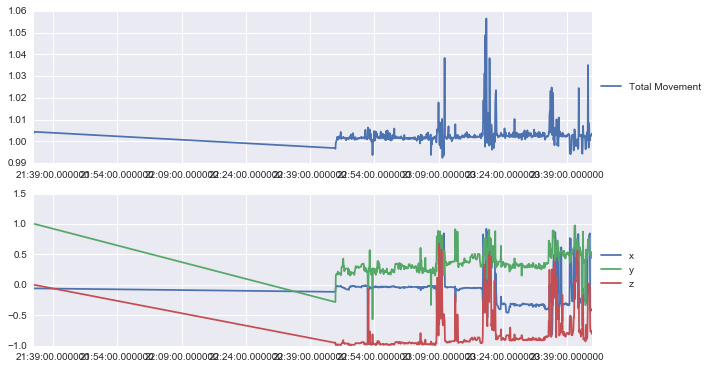

In [107]:
activity_types = ['stationary', 'walking', 'running', 'automotive', 'cycling', 'unknown']
cmap = plt.get_cmap('Pastel1')
colors = cmap(np.linspace(0, 1, len(activity_types)))

plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(bin_by_date(session.dist), label='Total Movement')
for _, item in motion.iterrows():
    label = item[['stationary', 'walking', 'running', 'automotive', 'cycling', 'unknown']].idxmax(axis=1)
    plt.plot(
        [item.date, item.endDate], [.8, .8],
        linewidth=15, color=colors[activity_types.index(label)],
        label=label, solid_capstyle='butt')

# HACK make sure we have unique labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(
    by_label.values(), by_label.keys(),
    loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.subplot(212)
plt.plot(binned_x, label='x')
plt.plot(binned_y, label='y')
plt.plot(binned_z, label='z')
_=plt.legend(
    loc='center left', bbox_to_anchor=(1, 0.5))

This next section is used to create labels of the above data that fit with rough intuitions of the behavior during the above periods. It wasn't precisely collected based on the behavior, and the data isn't at an appropriate time-scale for real-time intervention.

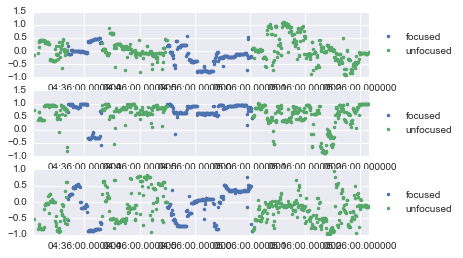

In [91]:
from pandas import Timestamp

focused_labels = [
    (Timestamp('2017-05-28 00:00:00.000000').to_datetime64(), 0),
    (Timestamp('2017-05-28 04:33:00.000000').to_datetime64(), 1),
    (Timestamp('2017-05-28 04:39:10.000000').to_datetime64(), 0),
    (Timestamp('2017-05-28 04:51:00.000000').to_datetime64(), 1),
    (Timestamp('2017-05-28 05:06:30.000000').to_datetime64(), 0),
    (Timestamp('2017-05-28 08:00:00.000000').to_datetime64(), None),
]

is_focused = np.zeros(items.shape)
for (start, focused), (end, _) in zip(focused_labels, focused_labels[1:]):
    if focused:
        is_focused = np.logical_or(is_focused, (start <= binned_times) & (binned_times < end))

for idx, items in enumerate([binned_x, binned_y, binned_z]):
    plt.subplot(3, 1, idx + 1)
    plt.plot(
        binned_times[is_focused], items[is_focused],
        '.', label='focused')
    plt.plot(
        binned_times[~is_focused], items[~is_focused],
        '.', label='unfocused')
    _=plt.legend(
        loc='center left', bbox_to_anchor=(1, 0.5))

In [134]:
binned_motion = np.vstack([binned_x, binned_y, binned_z]).T  # shape of (len(binned_x), 3)
units_back = 10

features = np.zeros((binned_motion.shape[0], binned_motion.shape[1] * units_back))
total_movement_features = np.zeros((binned_motion.shape[0], units_back))
agg_total_movement_features = np.zeros((binned_motion.shape[0], 1))
for idx in range(binned_motion.shape[0]):
    windowed = binned_motion[max(idx-units_back+1, 0):idx+1, :]
    if windowed.shape != (10, 3):
        # prepend zeros
        ow = windowed
        windowed = np.vstack([
            np.zeros((units_back - windowed.shape[0], windowed.shape[1])),
            windowed])
        print ow.shape, windowed.shape

    features[idx, 0:units_back] = windowed[:, 0]  # copy the X
    features[idx, units_back:2*units_back] = windowed[:, 1]  # copy the Y
    features[idx, 2*units_back:3*units_back] = windowed[:, 2]  # copy the Z

    total_movement_features[idx, :] = np.sqrt(
        windowed[:, 0] ** 2 +
        windowed[:, 1] ** 2 +
        windowed[:, 2] ** 2)

    agg_total_movement_features[idx] = np.mean(total_movement_features[idx, :])

features[0, :], features[binned_motion.shape[0] - 1, :]

(1, 3) (10, 3)
(2, 3) (10, 3)
(3, 3) (10, 3)
(4, 3) (10, 3)
(5, 3) (10, 3)
(6, 3) (10, 3)
(7, 3) (10, 3)
(8, 3) (10, 3)
(9, 3) (10, 3)


(array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       , -0.1627195,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.7480465,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       , -0.5185545]),
 array([-0.06311  , -0.095459 , -0.095703 , -0.094238 , -0.118164 ,
        -0.109619 , -0.10376  , -0.095459 , -0.079834 , -0.056641 ,
         0.986084 ,  0.986816 ,  0.984619 ,  0.980957 ,  0.980469 ,
         0.979614 ,  0.97876  ,  0.979736 ,  0.983398 ,  0.98584  ,
        -0.102783 , -0.087158 , -0.101074 , -0.1414795, -0.116455 ,
        -0.13855  , -0.138306 , -0.140381 , -0.123169 , -0.115479 ]))

In [131]:
from sklearn.decomposition import PCA
pca = PCA(n_components=14)
transformed = pca.fit_transform(features)
print pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)
print 'transformed.shape', transformed.shape

[ 0.40869572  0.17339888  0.10358425  0.06492617  0.0305882   0.02860523
  0.02603795  0.01857337  0.01827568  0.01440088  0.01135482  0.01090516
  0.01056745  0.00959694] 0.929510689941
transformed.shape (722, 14)


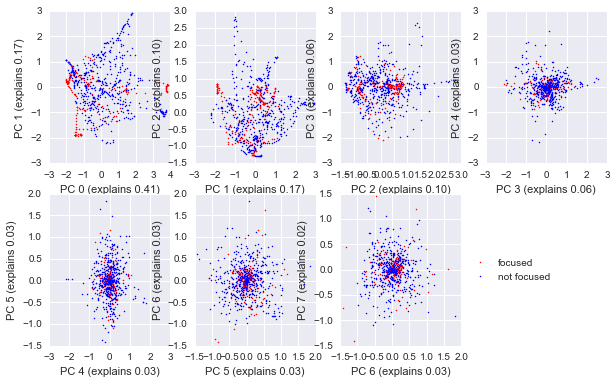

In [132]:
plt.figure(figsize=(10, 6))

for idx in range(transformed.shape[1] / 2):
    dim0 = idx
    dim1 = idx + 1
    plt.subplot(2, 4, idx + 1)
    plt.xlabel('PC {} (explains {:.2f})'.format(dim0, pca.explained_variance_ratio_[dim0]))
    plt.ylabel('PC {} (explains {:.2f})'.format(dim1, pca.explained_variance_ratio_[dim1]))
    plt.plot(
        transformed[is_focused, dim0], transformed[is_focused, dim1],
        'r.', label='focused', markersize=3)
    plt.plot(
        transformed[~is_focused, dim0], transformed[~is_focused, dim1],
        'b.', label='not focused', markersize=3)
_=plt.legend(
    loc='center left', bbox_to_anchor=(1, 0.5))

In [142]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

is_focused_int = is_focused.astype(np.int)

def model_with_features(features):
    X_train, X_test, y_train, y_test = train_test_split(
        features, is_focused_int, test_size=0.2, random_state=42)

    penalty = 1

    model = LogisticRegression(C=penalty)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print 'logistic regression, penalty', penalty, classification_report(
        y_test, y_pred, target_names=['not focused', 'focused'])

    for kernel in ['rbf', 'linear']:
        model = svm.SVC(kernel=kernel, C=penalty, class_weight='balanced')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print 'SVM, penalty', penalty, 'kernel', kernel, classification_report(
            y_test, y_pred, target_names=['not focused', 'focused'])

print 'modeling with xyz features', features.shape
model_with_features(features)

print 'modeling with total movement features', total_movement_features.shape
model_with_features(total_movement_features)

print 'modeling with agg total movement features', agg_total_movement_features.shape
model_with_features(agg_total_movement_features)

modeling with xyz features (722, 30)
logistic regression, penalty 1              precision    recall  f1-score   support

not focused       0.56      0.76      0.65        85
    focused       0.31      0.15      0.20        60

avg / total       0.46      0.51      0.46       145

SVM, penalty 1 kernel rbf              precision    recall  f1-score   support

not focused       0.79      0.69      0.74        85
    focused       0.63      0.73      0.68        60

avg / total       0.72      0.71      0.71       145

SVM, penalty 1 kernel linear              precision    recall  f1-score   support

not focused       0.62      0.40      0.49        85
    focused       0.43      0.65      0.52        60

avg / total       0.54      0.50      0.50       145

modeling with total movement features (722, 10)
logistic regression, penalty 1              precision    recall  f1-score   support

not focused       0.59      1.00      0.74        85
    focused       0.00      0.00      0.00    